# Packages

In [1]:
#basic packages
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
from datetime import datetime


#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# data modelling & results
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.model_selection import train_test_split
import math as math

#NN
import xgboost as xgb

from tensorflow import keras
from keras.utils.vis_utils import plot_model
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#feature importance
import shap


# Script

## Error computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
#errors computation

def errors_computation(data):
    
    df=pd.DataFrame()
    #df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    #df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    return df

In [5]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('')

In [6]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    
    x=power_curve['Wind Speed [m/s]']
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [7]:
def control_power_computation (data_test, data_train, power_curve):
    
    results_test=pd.DataFrame()
    results_train=pd.DataFrame()
    
    
    results_test=powercurve_computation(data_test, power_curve)
    results_train=powercurve_computation(data_train, power_curve)

    return results_test, results_train

In [8]:
def compute_results(data_test, data_train, power_curve, plot_error):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    print('')
    
    if plot_error:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    return print('Showing the results of the modelling: ')

In [9]:
def compute_results1(data_test, data_train, power_curve, plot_error):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    print('')
    print('Modelling errors in AEP terms for test set')
    data=AEP_computation(results_test, power_curve)
    
    if plot_error:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    print('Showing the results of the modelling: ')
    return data

In [10]:
def AEP_computation(data, power_curve):
    
    #binning the WS_Pred
    data['WS_pred_bin']=pd.cut(data['WS_pred'],
                                       bins=list(np.arange(-0.25,28.0,0.5)),
                                                 labels=list(np.arange(0.0,28.0,0.5)))

        
    #creating the AEP (Annual Energy Production table)
        
    AEP_table=pd.DataFrame()
    
    AEP_table['WS']=PC['Wind Speed [m/s]']
    AEP_table['WPC']=PC['Warranted Power Curve [kW]']
    AEP_table.set_index('WS', inplace=True)
    AEP_table['MPC_SC']=data.groupby('WS_pred_bin', as_index=True)['P'].mean()

    #puedo rellenar los NaN de MPC_SC copiando lo que tendría que ser: WPC
    
#     for i in AEP_table.index:
#         if math.isnan(AEP_table.at[i, 'MPC_SC']):
#             AEP_table.at[i, 'MPC_SC']=AEP_table.at[i, 'WPC']
    
    AEP_table['WSAD']=power_curve['Wind Speed Distribution [Hr/Year]']
    
    #o igual aquí tendría que cortar la tabla para NaN values
    
#     AEP_table=AEP_table.dropna()
    
    AEP_table['WAEP']=AEP_table['WPC']*AEP_table['WSAD']
    AEP_table['MAEP_SC']=AEP_table['MPC_SC']*AEP_table['WSAD']
    
    #computing the metrics for later printing
    
    MAEP_SC=AEP_table['MAEP_SC'].sum()
    WAEP=AEP_table['WAEP'].sum()
    AEP_perc=(MAEP_SC/WAEP)*100
    AEP_diff=(MAEP_SC-WAEP)/1000
    
    #printing the results

    print('')
    print('The computed AEP_table is: ')
    AEP_table(AEP_table)
    print('')
    print('The AEP% of the Site Calibration is: ', round(AEP_perc, 3), '%')
    print('')
    print('The AEP difference of the Site Calibration is: ', round(AEP_diff, 3), 'MWh')
    print('')
    AEP_plot(data, AEP_table)                                
    
    
    return data

In [11]:
def AEP_plot(data, AEP_table):
    
    #data is expected to contain: Target, WS_pred, P, P_pred
    #AEP_table is expected to contain: WS, WPC, MPC-SC

    #plotting the Power curves
    plt.figure(figsize=(10,6))
    plt.plot(data['WS_pred'], data['P'], marker='o', ls='', label='measured scatter', markersize=5, alpha=.1)
    plt.plot(AEP_table.index, AEP_table['WPC'], marker='o', color='black', linewidth=0.5, label='WPC', markersize=5)
    plt.plot(AEP_table.index, AEP_table['MPC_SC'], marker='o', color='red', linewidth=0.5, label='MPC-SC', markersize=5)


    plt.legend()

    ax=plt.gca()
    ax.set(ylabel='Power interpolated with WPC and Target WS (kW)', xlabel='Predicted Wind Speed (m/s)');
    ax.set_title('Site Calibration Power Curve')
    ax.set_xlim(xmin=0, xmax=20)
#     ax.set_xlim(xmin=0, xmax=27.5)
    
    return print('Error plot performed')

In [12]:
def AEP_table(AEP_table):
    
    #AEP_table is expected to contain: WPC, MPC_SC, WPC, WSAD, WAEP, MAEP
    
    WS= AEP_table.index
    WPC=AEP_table['WPC']
    MPC_SC=round(AEP_table['MPC_SC'],0)
    WSAD=AEP_table['WASD']
    WAEP=round(AEP_table['WAEP']/1000000, 3)
    MAEP=round(AEP_table['MAEP']/1000000, 3)
    

    row_headers=None
    column_headers=('Wind speed bin (m/s)', 'WPC (kW)', 'MPC_SC (kW)',
                    'Annual Wind Distribution (h/year)', 'WAEP (GWh)', 'MAEP (GWh)')

    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

    l_2d=[list(WS), list(WPC), list(MPC), list(WSAD), list(WAEP), list(MAEP)]

    cell_text=np.array(l_2d).T

    fig, ax = plt.subplots(figsize=(12,5)) 
    ax.set_axis_off()

    the_table=ax.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='right',
                      colColours=ccolors,
                      colLabels=column_headers,
                      cellLoc ='center',
                      loc='upper center',
                      colWidths = [0.1] * 5)

    ax.set_title('Annual Energy Production for Site Calibration PC', 
                 fontweight ="bold", fontsize=14) 

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    
    return ('AEP table printed')

## Data uploading

In [13]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [14]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

## Data selection

In [15]:
def data_selection(X_train, X_test, inputs):
    
    #this function returns the columns of the training and test sets in the inputs list
    
    X_train1 = pd.DataFrame()
    X_test1 = pd.DataFrame()
    
    
    X_train1 = X_train[inputs]
    X_test1 = X_test[inputs]

    
    return X_train1,X_test1

In [16]:
def data_drop(X_train, X_test, list_2drop):
    
    #this function returns the columns of the training and test sets in the inputs list

    X_train1 = X_train.drop(columns=list_2drop)
    X_test1 = X_test.drop(columns=list_2drop)

    
    
    return X_train1,X_test1

## Modelling

### Modelling XGBoost

In [17]:
def modelling_XGBoost (X, X_test, y, y_test, power_curve,  parameters, plot_error, plot):
    
    #creating the model
    max_depth=parameters['max_depth']
    n_estimators=parameters['n_estimators']
    learning_rate=parameters['learning_rate']
    subsample=parameters['subsample']
    colsample_bytree=parameters['colsample_bytree']
    min_child_weight=parameters['min_child_weight']
    gamma=parameters['gamma']
    reg_lambda=parameters['reg_lambda']
    
 
    model = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42,
                               objective='reg:squarederror', booster='gbtree', learning_rate=learning_rate,
                               subsample=subsample, colsample_bytree=colsample_bytree,
                             min_child_weight=min_child_weight, reg_lambda=reg_lambda)
                               
    #model fitting
    model.fit(X_train, y_train)
        
    
    #model predicting
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    
    data=compute_results(data_test, data_train, power_curve, plot_error)
    print('XGBoost modelling performed')
    
    return model

### Grid Search XGBoost

In [18]:
def GridSearch_XGBoost (X, X_test, y, y_test, power_curve, parameters, param_grid, plot_error):
    
    
    #counting the runing time
    start_time = time.time()
    
    #creating the model
    max_depth=parameters['max_depth']
    n_estimators=parameters['n_estimators']
    learning_rate=parameters['learning_rate']
    subsample=parameters['subsample']
    colsample_bytree=parameters['colsample_bytree']
    min_child_weight=parameters['min_child_weight']
    gamma=parameters['gamma']
    reg_lambda=parameters['reg_lambda']
    
    #creating the model
    xgbr = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42,
                           objective='reg:squarederror', booster='gbtree', learning_rate=learning_rate,
                           subsample=subsample, colsample_bytree=colsample_bytree,
                         min_child_weight=min_child_weight, gamma=gamma, reg_lambda=reg_lambda)
    
    
    
    #Grid Search CV
    clf = GridSearchCV(estimator=xgbr, 
                             param_grid=param_grid,
                             cv=4,
                             scoring='neg_mean_squared_error',
                             verbose=1) 
    
        
    #model fitting
    clf.fit(X_train, y_train)
    
    
    #model predicting
    
    y_pred_test=clf.predict(X_test)
    y_pred_train=clf.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(clf.best_params_)
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('GridSearch_ XGBoost performed')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')
    print('Lowest RMSE: ', (-clf.best_score_)**(1/2.0))
    
    
    
    return clf

### Random Search XGBoost

In [19]:
def RandomSearch_XGBoost(X, X_test, y, y_test, power_curve, param_distribs, plot_error):
    
    #counting the runing time
    start_time = time.time()
    
    
    #creating the model
    xgbr = xgb.XGBRegressor(random_state=42)
    
    #Random Search CV
    clf = RandomizedSearchCV(estimator=xgbr, 
                             param_distributions=param_distribs,
                             cv=4,
                             scoring='neg_mean_squared_error',
                             n_iter=25,
                             verbose=1) 
    
    
    #model fitting
    clf.fit(X_train, y_train)
    
    
    #model predicting
    
    y_pred_test=clf.predict(X_test)
    y_pred_train=clf.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(clf.best_params_)
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('RandomSearch_ XGBoost performed')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')
    print('Lowest RMSE: ', (-clf.best_score_)**(1/2.0))
    
    return clf
    

### Model Testing

In [20]:
def model_testing (X_train, X_test, y_train, y_test, power_curve, model, plot_error):

    

    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
        
    
    compute_results(data_test, data_train, power_curve, plot_error)
    
    WS_pred=data_test['WS_pred']
    print('XGBoost results performed')
    
    return WS_pred

### Feature importance

In [21]:
def feature_importance (X_train, X_test, model):
    
    X_t, X_f, y_t, y_f = train_test_split(X_train,y_train, test_size=0.02, random_state=12)
    
    background = X_f.copy()
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap_obj=explainer(X_test)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    shap.plots.beeswarm(shap_obj)
    
    
    shap_v=pd.DataFrame(shap_values)
    feature_list=X_test.columns
    shap_v.columns=feature_list
    shap_v=shap_v.abs()
    k=pd.DataFrame(shap_v.mean()).reset_index()
    k.columns=['variables','SHAP_abs']
    k.sort_values(by='variables')
    
    
    
    print('Feature importance through SHAP values performed')
    
    return k

# Data analysis

## Dataset2- T22

In [22]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train22.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test22.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train22.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test22.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'RH1',
       'PR1', 'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [23]:
y_test.keys()

Index(['Target'], dtype='object')

In [24]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V117.csv')

### Grid Search

In [25]:
parameters={
    'max_depth':5,
    'n_estimators': 1000,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [26]:
param_grid={
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

In [27]:
 GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best parameters :
{'n_estimators': 300}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.313 m/s as root mean
Wind MAE:  0.241 m/s in avg
Wind MAPE:  3.187 %
Power RMSE:  148.877 kW as root mean
Power MAE:  99.0 kW in avg
Power MAPE:  6898948843964908.0 %

Modelling errors for test set:
Wind RMSE:  0.709 m/s as root mean
Wind MAE:  0.535 m/s in avg
Wind MAPE:  7.011 %
Power RMSE:  335.969 kW as root mean
Power MAE:  219.307 kW in avg
Power MAPE:  21.232 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 1.9152118563652039 minutes ---

Lowest RMSE:  0.7451315432939063


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [28]:
parameters={
    'max_depth':5,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [29]:
param_grid={
    'max_depth': [3, 4, 5, 6, 10, 15, 20],
    'min_child_weight': [1, 2, 3, 6, 10]
}

In [30]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 35 candidates, totalling 140 fits

Best parameters :
{'max_depth': 15, 'min_child_weight': 10}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.019 m/s as root mean
Wind MAE:  0.012 m/s in avg
Wind MAPE:  0.162 %
Power RMSE:  8.975 kW as root mean
Power MAE:  4.882 kW in avg
Power MAPE:  0.495 %

Modelling errors for test set:
Wind RMSE:  0.71 m/s as root mean
Wind MAE:  0.53 m/s in avg
Wind MAPE:  6.943 %
Power RMSE:  335.85 kW as root mean
Power MAE:  217.118 kW in avg
Power MAPE:  21.06 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 8.26779154141744 minutes ---

Lowest RMSE:  0.731978040451494


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [31]:
parameters={
    'max_depth':15,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':1,
}

In [32]:
param_grid={
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [33]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits

Best parameters :
{'gamma': 0}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.019 m/s as root mean
Wind MAE:  0.012 m/s in avg
Wind MAPE:  0.162 %
Power RMSE:  8.975 kW as root mean
Power MAE:  4.882 kW in avg
Power MAPE:  0.495 %

Modelling errors for test set:
Wind RMSE:  0.71 m/s as root mean
Wind MAE:  0.53 m/s in avg
Wind MAPE:  6.943 %
Power RMSE:  335.85 kW as root mean
Power MAE:  217.118 kW in avg
Power MAPE:  21.06 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 2.0858511209487913 minutes ---

Lowest RMSE:  0.731978040451494


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=15, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None

In [34]:
parameters={
    'max_depth':15,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':1,
}

In [35]:
param_grid={
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [36]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Best parameters :
{'colsample_bytree': 0.8, 'subsample': 0.8}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.019 m/s as root mean
Wind MAE:  0.012 m/s in avg
Wind MAPE:  0.162 %
Power RMSE:  8.975 kW as root mean
Power MAE:  4.882 kW in avg
Power MAPE:  0.495 %

Modelling errors for test set:
Wind RMSE:  0.71 m/s as root mean
Wind MAE:  0.53 m/s in avg
Wind MAPE:  6.943 %
Power RMSE:  335.85 kW as root mean
Power MAE:  217.118 kW in avg
Power MAPE:  21.06 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 14.928577740987143 minutes ---

Lowest RMSE:  0.731978040451494


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=15, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None

In [37]:
parameters={
    'max_depth':15,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':1,
}

In [38]:
param_grid={
    'reg_lambda': [1, 10, 50, 100, 150]
}

In [39]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 5 candidates, totalling 20 fits

Best parameters :
{'reg_lambda': 10}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.049 m/s as root mean
Wind MAE:  0.033 m/s in avg
Wind MAPE:  0.436 %
Power RMSE:  22.284 kW as root mean
Power MAE:  13.016 kW in avg
Power MAPE:  133378150146385.97 %

Modelling errors for test set:
Wind RMSE:  0.693 m/s as root mean
Wind MAE:  0.521 m/s in avg
Wind MAPE:  6.835 %
Power RMSE:  331.23 kW as root mean
Power MAE:  213.785 kW in avg
Power MAPE:  20.596 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 1.5205266674359639 minutes ---

Lowest RMSE:  0.7226028890729834


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=15, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None

In [40]:
parameters={
    'max_depth':15,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':10,
}

In [41]:
param_grid={
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [800, 900, 1000, 1200, 1500, 1800, 2000]
}

In [42]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 28 candidates, totalling 112 fits

Best parameters :
{'learning_rate': 0.01, 'n_estimators': 2000}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.111 m/s as root mean
Wind MAE:  0.078 m/s in avg
Wind MAPE:  1.031 %
Power RMSE:  51.24 kW as root mean
Power MAE:  30.867 kW in avg
Power MAPE:  1988548677387365.5 %

Modelling errors for test set:
Wind RMSE:  0.677 m/s as root mean
Wind MAE:  0.507 m/s in avg
Wind MAPE:  6.661 %
Power RMSE:  319.97 kW as root mean
Power MAE:  206.049 kW in avg
Power MAPE:  20.305 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 19.994945323467256 minutes ---

Lowest RMSE:  0.7092060635553115


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=15, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=10,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=Non

### Manual modelling

In [43]:
parameters={
    'max_depth':15,
    'n_estimators': 2000,
    'learning_rate':0.01,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':10,
}

In [44]:
model = modelling_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.111 m/s as root mean
Wind MAE:  0.078 m/s in avg
Wind MAPE:  1.031 %
Power RMSE:  51.24 kW as root mean
Power MAE:  30.867 kW in avg
Power MAPE:  1988548677387365.5 %

Modelling errors for test set:
Wind RMSE:  0.677 m/s as root mean
Wind MAE:  0.507 m/s in avg
Wind MAPE:  6.661 %
Power RMSE:  319.97 kW as root mean
Power MAE:  206.049 kW in avg
Power MAPE:  20.305 %


Showing the results of the modelling: 
XGBoost modelling performed


### Feature importance

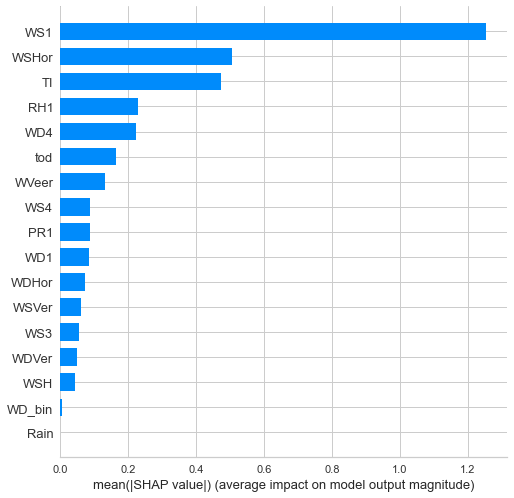

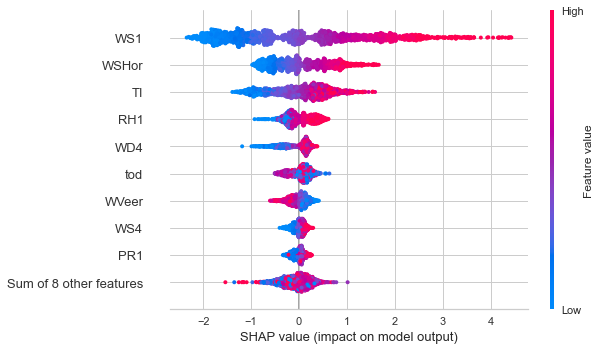

Feature importance through SHAP values performed


In [45]:
shap_values=feature_importance (X_train, X_test, model)

In [46]:
shap_values

,variables,SHAP_abs
0,WS1,1.252275
1,WS3,0.053266
2,WS4,0.088236
3,WD1,0.084821
4,WD4,0.223720
5,WSHor,0.504291
6,WSVer,0.059549
7,WDHor,0.072703
8,RH1,0.228495
9,PR1,0.087954


## Dataset2- T17

In [48]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train17.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test17.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train17.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test17.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'PR1',
       'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [49]:
y_test.keys()

Index(['Target'], dtype='object')

In [50]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V112.csv')

### Grid Search

In [51]:
parameters={
    'max_depth':5,
    'n_estimators': 1000,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [52]:
param_grid={
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

In [53]:
 GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best parameters :
{'n_estimators': 300}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.274 m/s as root mean
Wind MAE:  0.21 m/s in avg
Wind MAPE:  2.322 %
Power RMSE:  124.162 kW as root mean
Power MAE:  78.482 kW in avg
Power MAPE:  5.479 %

Modelling errors for test set:
Wind RMSE:  0.571 m/s as root mean
Wind MAE:  0.444 m/s in avg
Wind MAPE:  4.795 %
Power RMSE:  228.146 kW as root mean
Power MAE:  150.49 kW in avg
Power MAPE:  10.834 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 2.0538490374883014 minutes ---

Lowest RMSE:  0.5882572614848081


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [54]:
parameters={
    'max_depth':5,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [55]:
param_grid={
    'max_depth': [3, 4, 5, 6, 10, 15, 20],
    'min_child_weight': [1, 2, 3, 6, 10]
}

In [56]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 35 candidates, totalling 140 fits

Best parameters :
{'max_depth': 5, 'min_child_weight': 10}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.308 m/s as root mean
Wind MAE:  0.234 m/s in avg
Wind MAPE:  2.591 %
Power RMSE:  139.128 kW as root mean
Power MAE:  87.141 kW in avg
Power MAPE:  6.1 %

Modelling errors for test set:
Wind RMSE:  0.576 m/s as root mean
Wind MAE:  0.448 m/s in avg
Wind MAPE:  4.838 %
Power RMSE:  230.553 kW as root mean
Power MAE:  152.859 kW in avg
Power MAPE:  10.932 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 6.669050025939941 minutes ---

Lowest RMSE:  0.5824688218535748


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [57]:
parameters={
    'max_depth':5,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':1,
}

In [58]:
param_grid={
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [59]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits

Best parameters :
{'gamma': 0.1}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.305 m/s as root mean
Wind MAE:  0.232 m/s in avg
Wind MAPE:  2.558 %
Power RMSE:  137.71 kW as root mean
Power MAE:  86.198 kW in avg
Power MAPE:  6.002 %

Modelling errors for test set:
Wind RMSE:  0.578 m/s as root mean
Wind MAE:  0.45 m/s in avg
Wind MAPE:  4.861 %
Power RMSE:  231.781 kW as root mean
Power MAE:  153.612 kW in avg
Power MAPE:  11.008 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 0.6265353202819824 minutes ---

Lowest RMSE:  0.58234352670207


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [60]:
parameters={
    'max_depth':5,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0.1,
    'reg_lambda':1,
}

In [61]:
param_grid={
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [62]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Best parameters :
{'colsample_bytree': 1, 'subsample': 0.8}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.296 m/s as root mean
Wind MAE:  0.225 m/s in avg
Wind MAPE:  2.486 %
Power RMSE:  132.841 kW as root mean
Power MAE:  83.338 kW in avg
Power MAPE:  5.829 %

Modelling errors for test set:
Wind RMSE:  0.57 m/s as root mean
Wind MAE:  0.441 m/s in avg
Wind MAPE:  4.748 %
Power RMSE:  226.396 kW as root mean
Power MAE:  149.379 kW in avg
Power MAPE:  10.623 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 7.9996373097101845 minutes ---

Lowest RMSE:  0.579821074153776


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0.1, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=Non

In [63]:
parameters={
    'max_depth':5,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':1,
    'min_child_weight':10,
    'gamma':0.1,
    'reg_lambda':1,
}

In [64]:
param_grid={
    'reg_lambda': [1, 10, 50, 100, 150]
}

In [65]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 5 candidates, totalling 20 fits

Best parameters :
{'reg_lambda': 1}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.296 m/s as root mean
Wind MAE:  0.225 m/s in avg
Wind MAPE:  2.486 %
Power RMSE:  132.841 kW as root mean
Power MAE:  83.338 kW in avg
Power MAPE:  5.829 %

Modelling errors for test set:
Wind RMSE:  0.57 m/s as root mean
Wind MAE:  0.441 m/s in avg
Wind MAPE:  4.748 %
Power RMSE:  226.396 kW as root mean
Power MAE:  149.379 kW in avg
Power MAPE:  10.623 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 0.657681401570638 minutes ---

Lowest RMSE:  0.579821074153776


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1,
                                    gamma=0.1, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [66]:
parameters={
    'max_depth':5,
    'n_estimators': 300,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':1,
    'min_child_weight':10,
    'gamma':0.1,
    'reg_lambda':1,
}

In [67]:
param_grid={
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [800, 900, 1000, 1200, 1500, 1800, 2000]
}

In [68]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 28 candidates, totalling 112 fits

Best parameters :
{'learning_rate': 0.01, 'n_estimators': 2000}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.348 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  2.933 %
Power RMSE:  155.407 kW as root mean
Power MAE:  98.184 kW in avg
Power MAPE:  6.839 %

Modelling errors for test set:
Wind RMSE:  0.565 m/s as root mean
Wind MAE:  0.44 m/s in avg
Wind MAPE:  4.743 %
Power RMSE:  225.776 kW as root mean
Power MAE:  149.54 kW in avg
Power MAPE:  10.683 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 16.78581728140513 minutes ---

Lowest RMSE:  0.5736045603820564


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1,
                                    gamma=0.1, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=300, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

### Manual modelling

In [69]:
parameters={
    'max_depth':5,
    'n_estimators': 2000,
    'learning_rate':0.01,
    'subsample':0.8,
    'colsample_bytree':1,
    'min_child_weight':10,
    'gamma':0.1,
    'reg_lambda':1,
}

In [70]:
model = modelling_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.348 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  2.93 %
Power RMSE:  155.297 kW as root mean
Power MAE:  98.071 kW in avg
Power MAPE:  6.829 %

Modelling errors for test set:
Wind RMSE:  0.564 m/s as root mean
Wind MAE:  0.439 m/s in avg
Wind MAPE:  4.732 %
Power RMSE:  225.506 kW as root mean
Power MAE:  149.24 kW in avg
Power MAPE:  10.649 %


Showing the results of the modelling: 
XGBoost modelling performed


### Feature importance

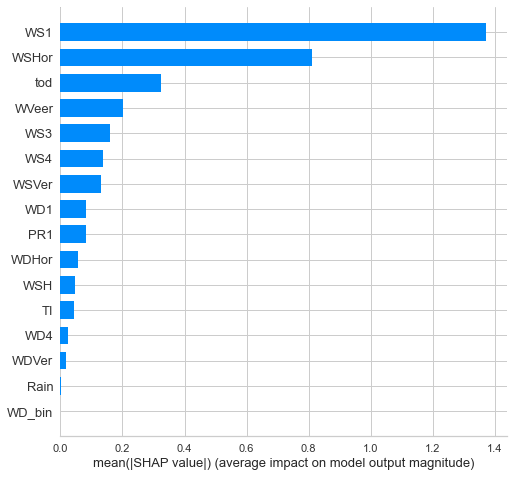

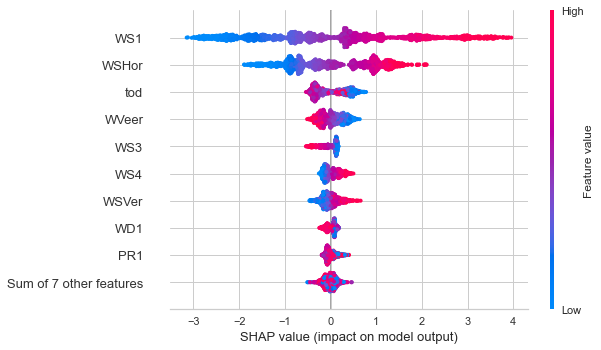

Feature importance through SHAP values performed


In [71]:
shap_values=feature_importance (X_train, X_test, model)

In [72]:
shap_values

,variables,SHAP_abs
0,WS1,1.370562
1,WS3,0.160231
2,WS4,0.135672
3,WD1,0.082448
4,WD4,0.024685
5,WSHor,0.812333
6,WSVer,0.130960
7,WDHor,0.055316
8,PR1,0.081576
9,Rain,0.001871


## Dataset2- T11

In [22]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train11.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test11.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train11.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test11.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'T1',
       'RH1', 'PR1', 'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'AD1',
       'tod'],
      dtype='object')

In [23]:
y_test.keys()

Index(['Target'], dtype='object')

In [24]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V117.csv')

### Grid Search

In [25]:
parameters={
    'max_depth':5,
    'n_estimators': 1000,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [26]:
param_grid={
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

In [27]:
 GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best parameters :
{'n_estimators': 400}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.317 m/s as root mean
Wind MAE:  0.242 m/s in avg
Wind MAPE:  2.589 %
Power RMSE:  128.749 kW as root mean
Power MAE:  72.657 kW in avg
Power MAPE:  732529930397887.8 %

Modelling errors for test set:
Wind RMSE:  0.776 m/s as root mean
Wind MAE:  0.528 m/s in avg
Wind MAPE:  10.119 %
Power RMSE:  287.74 kW as root mean
Power MAE:  152.144 kW in avg
Power MAPE:  2.0467621195303985e+18 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 3.470446352163951 minutes ---

Lowest RMSE:  0.7298377308609298


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [28]:
parameters={
    'max_depth':5,
    'n_estimators': 400,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [29]:
param_grid={
    'max_depth': [3, 4, 5, 6, 10, 15, 20],
    'min_child_weight': [1, 2, 3, 6, 10]
}

In [30]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 35 candidates, totalling 140 fits

Best parameters :
{'max_depth': 4, 'min_child_weight': 6}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.438 m/s as root mean
Wind MAE:  0.334 m/s in avg
Wind MAPE:  3.741 %
Power RMSE:  174.555 kW as root mean
Power MAE:  98.948 kW in avg
Power MAPE:  1772610022654530.8 %

Modelling errors for test set:
Wind RMSE:  0.772 m/s as root mean
Wind MAE:  0.535 m/s in avg
Wind MAPE:  9.829 %
Power RMSE:  287.399 kW as root mean
Power MAE:  155.219 kW in avg
Power MAPE:  1.7732662376528412e+18 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 14.422153608004253 minutes ---

Lowest RMSE:  0.719365345257246


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [31]:
parameters={
    'max_depth':4,
    'n_estimators': 400,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':1,
}

In [32]:
param_grid={
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [33]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits

Best parameters :
{'gamma': 0}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.438 m/s as root mean
Wind MAE:  0.334 m/s in avg
Wind MAPE:  3.741 %
Power RMSE:  174.555 kW as root mean
Power MAE:  98.948 kW in avg
Power MAPE:  1772610022654530.8 %

Modelling errors for test set:
Wind RMSE:  0.772 m/s as root mean
Wind MAE:  0.535 m/s in avg
Wind MAPE:  9.829 %
Power RMSE:  287.399 kW as root mean
Power MAE:  155.219 kW in avg
Power MAPE:  1.7732662376528412e+18 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 1.1639374136924743 minutes ---

Lowest RMSE:  0.719365345257246


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=4, min_child_weight=6,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [34]:
parameters={
    'max_depth':4,
    'n_estimators': 400,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':1,
}

In [35]:
param_grid={
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [36]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Best parameters :
{'colsample_bytree': 0.8, 'subsample': 0.8}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.438 m/s as root mean
Wind MAE:  0.334 m/s in avg
Wind MAPE:  3.741 %
Power RMSE:  174.555 kW as root mean
Power MAE:  98.948 kW in avg
Power MAPE:  1772610022654530.8 %

Modelling errors for test set:
Wind RMSE:  0.772 m/s as root mean
Wind MAE:  0.535 m/s in avg
Wind MAPE:  9.829 %
Power RMSE:  287.399 kW as root mean
Power MAE:  155.219 kW in avg
Power MAPE:  1.7732662376528412e+18 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 7.994244949022929 minutes ---

Lowest RMSE:  0.719365345257246


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=4, min_child_weight=6,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [37]:
parameters={
    'max_depth':4,
    'n_estimators': 400,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':1,
}

In [38]:
param_grid={
    'reg_lambda': [1, 10, 50, 100, 150]
}

In [39]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 5 candidates, totalling 20 fits

Best parameters :
{'reg_lambda': 1}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.438 m/s as root mean
Wind MAE:  0.334 m/s in avg
Wind MAPE:  3.741 %
Power RMSE:  174.555 kW as root mean
Power MAE:  98.948 kW in avg
Power MAPE:  1772610022654530.8 %

Modelling errors for test set:
Wind RMSE:  0.772 m/s as root mean
Wind MAE:  0.535 m/s in avg
Wind MAPE:  9.829 %
Power RMSE:  287.399 kW as root mean
Power MAE:  155.219 kW in avg
Power MAPE:  1.7732662376528412e+18 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 0.9938191890716552 minutes ---

Lowest RMSE:  0.719365345257246


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=4, min_child_weight=6,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [40]:
parameters={
    'max_depth':4,
    'n_estimators': 400,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':1,
}

In [41]:
param_grid={
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [800, 900, 1000, 1200, 1500, 1800, 2000]
}

In [42]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 28 candidates, totalling 112 fits

Best parameters :
{'learning_rate': 0.1, 'n_estimators': 800}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.318 m/s as root mean
Wind MAE:  0.243 m/s in avg
Wind MAPE:  2.644 %
Power RMSE:  129.691 kW as root mean
Power MAE:  72.679 kW in avg
Power MAPE:  624015738884611.0 %

Modelling errors for test set:
Wind RMSE:  0.771 m/s as root mean
Wind MAE:  0.537 m/s in avg
Wind MAPE:  9.778 %
Power RMSE:  287.077 kW as root mean
Power MAE:  154.934 kW in avg
Power MAPE:  1.7488463180140452e+18 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 17.68613919814428 minutes ---

Lowest RMSE:  0.7215173312433454


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=4, min_child_weight=6,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


### Manual modelling

In [25]:
parameters={
    'max_depth':4,
    'n_estimators': 800,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':1
}

In [26]:
model = modelling_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.318 m/s as root mean
Wind MAE:  0.243 m/s in avg
Wind MAPE:  2.644 %
Power RMSE:  129.691 kW as root mean
Power MAE:  72.679 kW in avg
Power MAPE:  624015738884611.0 %

Modelling errors for test set:
Wind RMSE:  0.771 m/s as root mean
Wind MAE:  0.537 m/s in avg
Wind MAPE:  9.778 %
Power RMSE:  287.077 kW as root mean
Power MAE:  154.934 kW in avg
Power MAPE:  1.7488463180140452e+18 %


Showing the results of the modelling: 
XGBoost modelling performed


### Model testing

In [27]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.318 m/s as root mean
Wind MAE:  0.243 m/s in avg
Wind MAPE:  2.644 %
Power RMSE:  129.691 kW as root mean
Power MAE:  72.679 kW in avg
Power MAPE:  624015738884611.0 %

Modelling errors for test set:
Wind RMSE:  0.771 m/s as root mean
Wind MAE:  0.537 m/s in avg
Wind MAPE:  9.778 %
Power RMSE:  287.077 kW as root mean
Power MAE:  154.934 kW in avg
Power MAPE:  1.7488463180140452e+18 %


Showing the results of the modelling: 
XGBoost results performed


In [28]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','XGB_T11.csv')

file XGB_T11.csv saved in \Results_ folder


### Feature importance

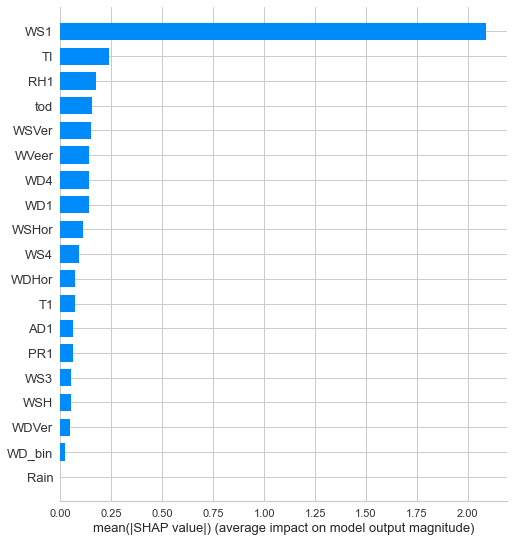

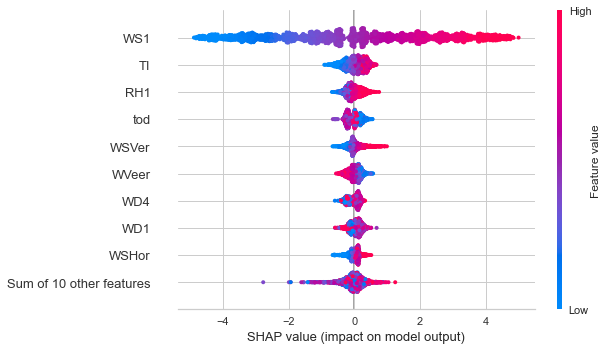

Feature importance through SHAP values performed


In [45]:
shap_values=feature_importance (X_train, X_test, model)

In [47]:
shap_values

,variables,SHAP_abs
0,WS1,2.086963
1,WS3,0.052639
2,WS4,0.088967
3,WD1,0.138245
4,WD4,0.139437
5,WSHor,0.112252
6,WSVer,0.151783
7,WDHor,0.073669
8,T1,0.072853
9,RH1,0.173812
